In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler
from torchaudio import datasets

from loader import collate_function
from models import DSVAE as TeacherDSVAE
from teacherstudent.models import StudentDSVAE

In [ ]:
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")
torch.mps.empty_cache()

In [ ]:
def kld_with_any(mean_c, logvar_c, mean_wav, var_wav):
    return 0.5 * (
        torch.log(var_wav / logvar_c)
        + (logvar_c + (mean_c - mean_wav) ** 2) / var_wav
        - 1
    )


def kld_with_normal(mean, logvar):
    return -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())


def recon_loss(x, recon_x):
    return F.mse_loss(recon_x, x)


def loss_function(x, recon_x, mean_s, logvar_s, mean_c, logvar_c):
    return (
        recon_loss(x, recon_x)
        + kld_with_normal(mean_s, logvar_s)
        + kld_with_normal(mean_c, logvar_c)
    )

def student_loss_function(x, teacher_x, student_x):
    return F.mse_loss(student_x, x) + F.mse_loss(student_x, teacher_x)

In [ ]:
train_data = datasets.VCTK_092("./", download=True)
train_data_loader = DataLoader(
    train_data,
    batch_size=2,
    collate_fn=lambda batch: collate_function(batch),
    sampler=RandomSampler(train_data, num_samples=400)
)
epochs = 2
teacher_losses = []
student_losses = []

In [ ]:
teacher_model = TeacherDSVAE()
teacher_model.to(device)
teacher_optimizer = torch.optim.Adam(teacher_model.parameters(), lr=1e-3)

In [ ]:
student_model = StudentDSVAE()
student_model.to(device)
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)

In [ ]:
torch.mps.empty_cache()
for epoch in range(epochs):
    teacher_model.train()
    teacher_train_loss = 0

    student_model.train()
    student_train_loss = 0

    for batch_idx, (x, _) in enumerate(train_data_loader):
        x = x.to(device)

        recon_x, mean_s, logvar_s, mean_c, logvar_c = teacher_model(x)
        teacher_loss = loss_function(x, recon_x, mean_s, logvar_s, mean_c, logvar_c)
        teacher_loss.backward()
        teacher_optimizer.step()
        teacher_optimizer.zero_grad()

        student_recon_x, _, _, _, _ = student_model(recon_x)
        student_loss = student_loss_function(x, recon_x.detach(), student_recon_x)
        student_loss.backward()
        student_optimizer.step()
        student_optimizer.zero_grad()

        teacher_train_loss += teacher_loss.item()
        student_train_loss += student_loss.item()
        print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}/{len(train_data_loader)}, Teacher Loss {teacher_loss.item():.4f}, Student Loss {student_loss.item():.4f}")

    teacher_avg = teacher_train_loss / len(train_data_loader)
    teacher_losses.append(teacher_avg)

    student_avg = student_train_loss / len(train_data_loader)
    student_losses.append(student_avg)

    print(f"Epoch {epoch+1}, Teacher Loss: {teacher_avg:.4f}, Student Loss: {student_avg:.4f}")

print("Done!")

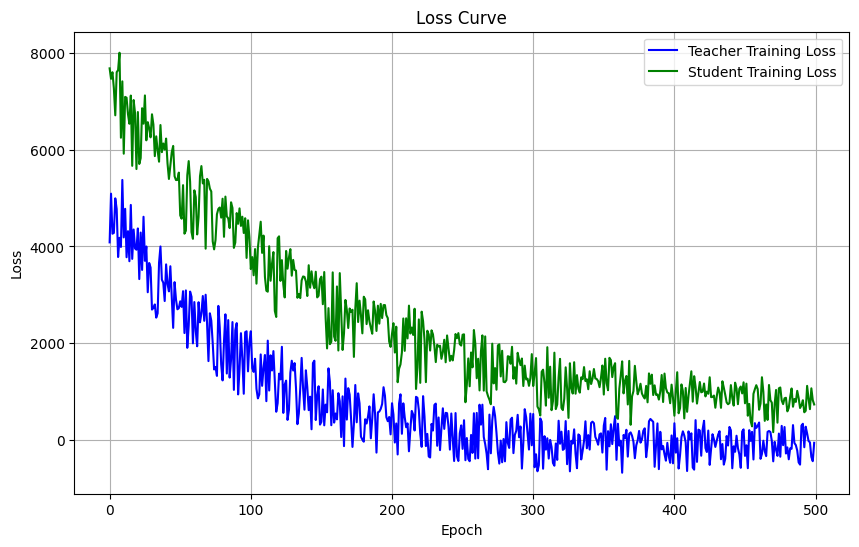

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(teacher_losses, label="Teacher Training Loss", color="blue")
plt.plot(student_losses, label="Student Training Loss", color="green")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
torch.save(teacher_model.state_dict, 'vt1.pth')
torch.save(student_model.state_dict, 'vs1.pth')

In [ ]:
def reparameterize(mean, logvar):
    std = torch.exp(0.5 * logvar)
    epsilon = torch.randn_like(std)

    return mean + epsilon * std

def concat(z_s, z_c):
    concat_z = torch.cat((z_s, z_c), dim=1)
    return concat_z.unsqueeze(1)

In [ ]:
t_z_s = reparameterize(teacher_model.mean_s, teacher_model.logvar_s)
t_z_c = reparameterize(teacher_model.mean_c, teacher_model.logvar_c)
t_concat_z = concat(t_z_s, t_z_c)

In [ ]:
t = teacher_model.decoder(t_concat_z)

In [ ]:
tt = t.cpu().detach().numpy()

In [ ]:
plt.figure(figsize=(10, 4))
plt.imshow(tt[0][0], aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Time (frames)")
plt.ylabel("Mel Frequency")
plt.title("Mel Spectrogram")

In [ ]:
s_z_s = reparameterize(student_model.mean_s, student_model.logvar_s)
s_z_c = reparameterize(student_model.mean_c, student_model.logvar_c)
s_concat_z = concat(s_z_s, s_z_c)

In [ ]:
s = student_model.decoder(s_concat_z)

In [ ]:
ss = s.cpu().detach().numpy()

In [ ]:
plt.figure(figsize=(10, 4))
plt.imshow(ss[0][0], aspect="auto", origin="lower", cmap="viridis")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Time (frames)")
plt.ylabel("Mel Frequency")
plt.title("Mel Spectrogram")

In [ ]:
from vocoder import mel_to_wave
import torchaudio

In [ ]:
a = mel_to_wave(tt)
b = mel_to_wave(ss)
torchaudio.save("t.wav", a[0], 96000)
torchaudio.save("s.wav", b[0], 96000)

In [ ]:
F.mse_loss(teacher_model.decoder(t_concat_z), student_model.decoder(s_concat_z))